# 밀도 추정 (Density Estimation)

**Jun Song**

이 노트북에서는 데이터의 분포를 추정하는 강력한 방법인 **밀도 추정**에 대해 알아봅니다. 데이터가 어떤 확률 분포로부터 생성되었는지를 추정하는 것은 데이터의 기저에 있는 패턴과 구조를 이해하는 데 매우 중요합니다.

여기서는 대표적인 밀도 추정 방법인 **Histogram**과 **Kernel Density Estimation**을 다룹니다.

**- 신규 추가 라이브러리:** `astropy` (히스토그램 구간을 최적화하기 위해 사용)

In [10]:
# 기본적인 데이터 시각화 및 분석을 위한 라이브러리를 불러옵니다.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 스타일 설정을 통해 플롯을 더 보기 좋게 만듭니다.
sns.set_style('whitegrid')

## 1. 히스토그램 (Histogram)

히스토그램은 데이터를 특정 구간(bin)으로 나눈 뒤, 각 구간에 속하는 데이터의 개수를 막대로 표현하여 데이터의 분포를 시각적으로 보여주는 가장 기본적인 밀도 추정 방법입니다.

### 1.1 예제 데이터 생성

먼저, 두 개의 정규분포가 섞인 것 같은 형태의 데이터를 생성해 보겠습니다. 이러한 데이터는 실제 세계에서 흔히 발견되는 복합적인 분포를 시뮬레이션합니다.

In [11]:
# 두 개의 정규분포를 혼합한 데이터를 생성하는 함수입니다.
def make_data(N, f=0.3, rseed=1):
    """
    N: 생성할 총 데이터 개수
    f: 첫 번째 분포가 전체 데이터에서 차지하는 비율
    rseed: 재현 가능성을 위한 랜덤 시드
    """
    # 랜덤 시드 고정
    rand = np.random.RandomState(rseed)
    
    # N개의 데이터를 정규분포로부터 샘플링합니다.
    x = rand.randn(N)
    
    # 데이터의 일부(N * f 개수 이후)에 5를 더하여 두 번째 분포를 만듭니다.
    # 결과적으로 평균이 0과 5인 두 개의 정규분포가 섞인 데이터가 생성됩니다.
    x[int(f * N):] += 5
    return x

# 1000개의 샘플 데이터 생성
x = make_data(1000)

### 1.2 기본 히스토그램 시각화

생성된 데이터를 사용하여 기본적인 히스토그램을 그려보겠습니다. `plt.hist` 함수는 데이터를 여러 구간으로 나누고 각 구간의 데이터 빈도를 계산하여 막대그래프로 보여줍니다.

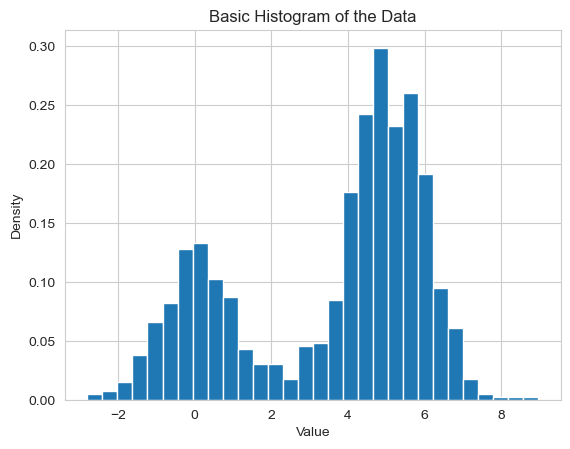

In [12]:
# 데이터의 분포를 히스토그램으로 시각화합니다.
# bins 파라미터는 데이터를 몇 개의 구간으로 나눌지를 결정합니다.
plt.hist(x, bins=30, density=True)
plt.title('Basic Histogram of the Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

**히스토그램의 문제점: 구간(Bin) 크기에 따른 민감성**

히스토그램의 가장 큰 단점은 **구간의 개수(또는 너비)를 어떻게 설정하느냐에 따라 결과가 크게 달라진다**는 것입니다. 구간이 너무 넓으면 데이터의 세부적인 분포 구조를 파악하기 어렵고, 너무 좁으면 노이즈가 부각되어 전체적인 패턴을 보기 어렵습니다.

아래 예시를 통해 구간 개수(`bins`) 변경에 따라 히스토그램이 어떻게 변하는지 확인해 보겠습니다.

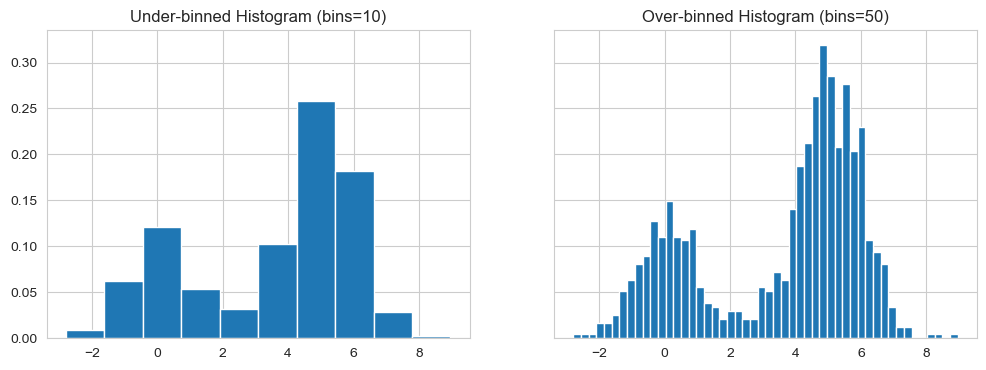

In [13]:
# 구간(bin) 개수에 따라 히스토그램이 어떻게 변하는지 비교합니다.
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

# 왼쪽: 구간이 10개로 너무 넓은 경우 (Under-binned)
# 데이터의 세부적인 봉우리(peak)가 하나로 뭉개져 보입니다.
axes[0].hist(x, bins=10, density=True)
axes[0].set_title("Under-binned Histogram (bins=10)")

# 오른쪽: 구간이 50개로 너무 좁은 경우 (Over-binned)
# 노이즈가 너무 부각되어 실제 데이터의 분포를 파악하기 어렵습니다.
axes[1].hist(x, bins=50, density=True)
axes[1].set_title("Over-binned Histogram (bins=50)")

plt.show()

### 1.3 최적의 구간 개수 찾기

이처럼 구간 설정의 민감성 때문에, 데이터에 기반하여 최적의 구간 개수를 결정하는 여러 규칙들이 제안되었습니다. 대표적으로 **Freedman-Diaconis Rule**과 **Scott's Rule**이 있습니다.

`astropy` 라이브러리는 이러한 규칙들을 편리하게 사용할 수 있는 기능을 제공합니다.

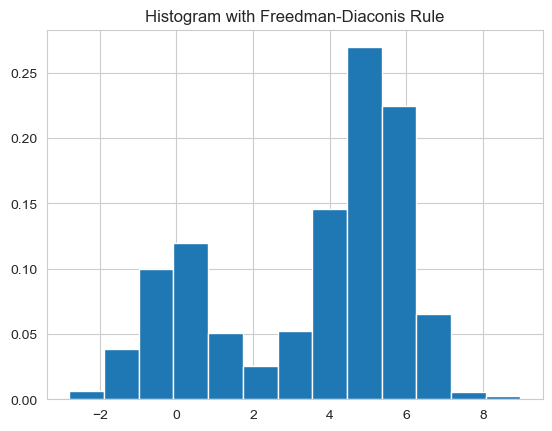

In [14]:
# astropy 라이브러리를 사용하여 최적의 구간 개수를 계산합니다.
from astropy.visualization import hist

# Freedman-Diaconis 규칙을 사용하여 히스토그램을 그립니다.
# 이 규칙은 데이터의 사분위수 범위를 사용하여 구간 너비를 결정하므로,
# 이상치(outlier)에 덜 민감한 장점이 있습니다.
hist(x, bins='freedman', density=True)
plt.title('Histogram with Freedman-Diaconis Rule')
plt.show()

## 2. 커널 밀도 추정 (Kernel Density Estimation, KDE)

**커널 밀도 추정**은 히스토그램의 단점을 보완하는 비모수적(non-parametric) 밀도 추정 방법입니다. 히스토그램처럼 데이터를 불연속적인 구간으로 나누는 대신, 각 데이터 포인트 위에 **kernel**이라는 부드러운 함수(예: 가우시안 함수)를 분포시킨 후, 모든 커널 함수의 합을 구하여 전체 데이터의 밀도 함수를 추정합니다.

이를 통해 히스토그램보다 훨씬 부드럽고 연속적인 밀도 곡선을 얻을 수 있습니다.



### 2.1 KDE 시각화

`seaborn` 라이브러리의 `kdeplot` 함수나 `scikit-learn`의 `KernelDensity`를 사용하여 쉽게 KDE를 시각화할 수 있습니다.

/var/folders/jm/gcky32gs3ls229wh_l9qlfb00000gn/T/ipykernel_12079/186128410.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x, shade=True)


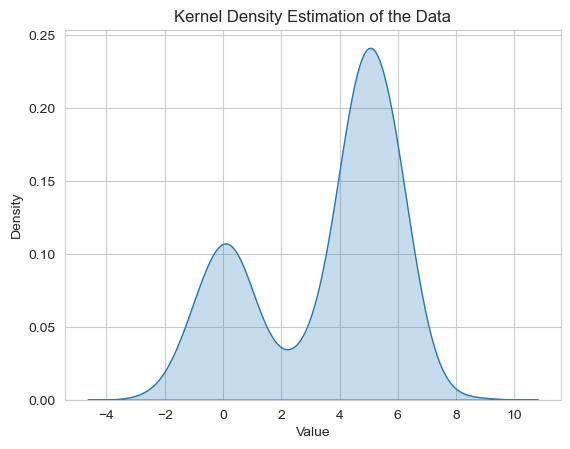

In [15]:
# seaborn 라이브러리를 사용하여 KDE 플롯을 그립니다.
# KDE는 히스토그램보다 훨씬 부드러운 밀도 추정 곡선을 제공합니다.
sns.kdeplot(x, shade=True)
plt.title('Kernel Density Estimation of the Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

**KDE의 문제점: 대역폭(Bandwidth) 선택**

KDE 역시 히스토그램의 구간 너비와 비슷한 **bandwidth**라는 파라미터에 민감합니다. 대역폭은 각 커널 함수의 '폭'을 결정하며, 이 값이 너무 크면 곡선이 지나치게 부드러워져(과소적합, under-smoothing) 세부 구조를 놓치게 되고, 너무 작으면 곡선이 지나치게 뾰족해져(과대적합, over-smoothing) 노이즈를 실제 분포로 오인할 수 있습니다.

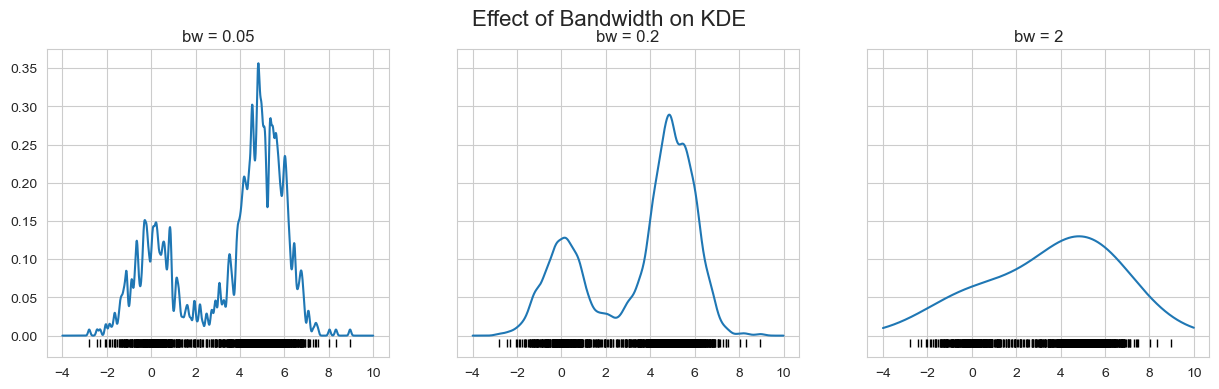

In [16]:
# Scikit-learn의 KernelDensity를 사용하여 대역폭(bandwidth)의 영향을 확인합니다.
from sklearn.neighbors import KernelDensity

# 대역폭 값들을 리스트로 정의
bandwidths = [0.05, 0.2, 2]

# 그림판 설정
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
fig.suptitle('Effect of Bandwidth on KDE', fontsize=16)

# x축 범위 설정
x_grid = np.linspace(-4, 10, 1000)

# 각 대역폭에 대해 KDE 모델을 학습하고 밀도를 계산하여 시각화
for bw, ax in zip(bandwidths, axes):
    # 1. KDE 모델 생성 (커널은 가우시안, 대역폭은 bw로 설정)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw)
    
    # 2. 데이터 학습 (데이터 형태를 [n_samples, n_features]로 변경)
    kde.fit(x[:, np.newaxis])
    
    # 3. 새로운 x_grid에 대한 로그 밀도 계산
    log_dens = kde.score_samples(x_grid[:, np.newaxis])
    
    # 4. 로그 밀도를 실제 밀도로 변환하여 플롯
    ax.plot(x_grid, np.exp(log_dens))
    
    # 5. 원본 데이터의 위치를 점(rug plot)으로 표시
    ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    
    ax.set_title(f'bw = {bw}')

plt.show()

# bw=0.05: 과대적합 (Over-smoothing), 노이즈까지 모두 표현하려 함.
# bw=0.2: 적절한 대역폭. 데이터의 두 봉우리를 잘 표현함.
# bw=2: 과소적합 (Under-smoothing), 전체를 하나의 뭉툭한 봉우리로 표현함.

### 2.2 최적의 대역폭 찾기: 교차 검증 (Cross-Validation)

최적의 대역폭을 찾는 것은 매우 중요한 문제입니다. `scikit-learn`에서는 **그리드 서치(Grid Search)**와 **교차 검증(Cross-Validation)**을 통해 데이터에 가장 적합한 대역폭을 자동으로 찾을 수 있습니다.

In [17]:
# 그리드 서치를 사용해 최적의 대역폭을 찾습니다.
from sklearn.model_selection import GridSearchCV, LeaveOneOut

# 탐색할 대역폭의 범위 설정 (로그 스케일)
bandwidths = 10 ** np.linspace(-1, 1, 100)

# GridSearchCV 설정
# KernelDensity 모델에 대해 'bandwidth' 파라미터를 탐색합니다.
# cv=LeaveOneOut()은 각 데이터를 한 번씩 검증 데이터로 사용하는 교차 검증 방식입니다.
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut(),
                    n_jobs=-1)

# 데이터 학습 (그리드 서치 시작)
grid.fit(x[:, None]);

Best bandwidth found: 0.35


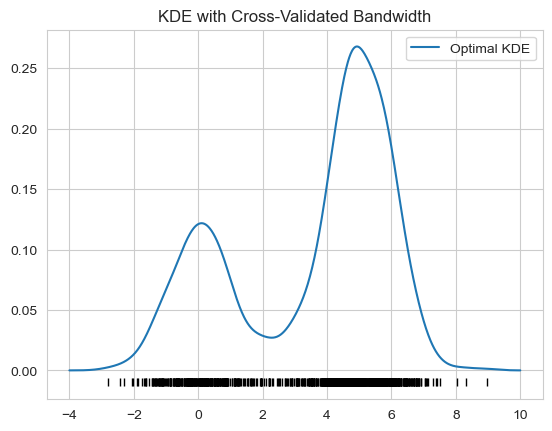

In [18]:
# 그리드 서치를 통해 찾은 최적의 대역폭을 출력합니다.
best_bw = grid.best_params_['bandwidth']
print(f"Best bandwidth found: {best_bw:.2f}")

# 최적의 대역폭을 사용하여 KDE 모델을 다시 학습하고 시각화합니다.
kde = KernelDensity(kernel='gaussian', bandwidth=best_bw)
kde.fit(x[:, np.newaxis])
log_dens = kde.score_samples(x_grid[:, np.newaxis])

plt.plot(x_grid, np.exp(log_dens), label='Optimal KDE')
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.title('KDE with Cross-Validated Bandwidth')
plt.legend()
plt.show()

## 3. 예제: 손글씨 숫자 데이터 생성

KDE는 단순히 데이터의 분포를 시각화하는 것을 넘어, 기존 데이터의 분포를 학습하여 **Generative Model**로 확장할 수 있습니다.

여기서는 `scikit-learn`에 내장된 손글씨 숫자 데이터셋을 사용하여 KDE 모델을 학습시킨 후, 이 모델로부터 새로운 손글씨 숫자 이미지를 생성해 보겠습니다.

In [19]:
# 손글씨 숫자 데이터셋을 로드합니다.
from sklearn.datasets import load_digits
digits = load_digits()

# 데이터셋의 형태 확인
# 1797개의 이미지, 각 이미지는 64개의 픽셀(8x8)로 구성됨
print("Data shape:", digits.data.shape)

Data shape: (1797, 64)


### 3.1 차원 축소: PCA

손글씨 데이터는 64차원의 고차원 데이터입니다. 고차원 데이터에 KDE를 직접 적용하면 계산이 매우 복잡하고 '차원의 저주' 문제로 인해 성능이 저하될 수 있습니다.

따라서 **주성분 분석(Principal Component Analysis, PCA)**을 사용하여 데이터의 차원을 64차원에서 더 낮은 차원(여기서는 15차원)으로 축소합니다. PCA는 데이터의 분산을 최대한 보존하는 새로운 축(주성분)을 찾아 데이터를 변환하는 기법입니다.

In [20]:
# PCA를 사용하여 데이터의 차원을 64에서 15로 축소합니다.
from sklearn.decomposition import PCA

# n_components=15: 15개의 주성분만 사용
# svd_solver='randomized': 대규모 데이터셋에 효율적인 SVD(특이값 분해) 계산 방식
pca = PCA(n_components=15, svd_solver='randomized')

# PCA 모델 학습 및 데이터 변환
data_pca = pca.fit_transform(digits.data)

# 차원이 축소된 데이터의 형태 확인
print("PCA-transformed data shape:", data_pca.shape)

PCA-transformed data shape: (1797, 15)


### 3.2 KDE 모델 학습

이제 차원이 축소된 15차원 데이터에 KDE 모델을 학습시킵니다. 교차 검증을 통해 최적의 대역폭을 찾습니다.

In [21]:
# 차원 축소된 데이터에 대해 그리드 서치를 사용하여 최적의 대역폭을 찾습니다.
# 계산 시간을 줄이기 위해 100개의 데이터만 샘플링하여 사용하고,
# 교차 검증 폴드(fold) 수를 5로 설정합니다.
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.logspace(-1, 1, 20)},
                    cv=5,
                    n_jobs=-1) # 모든 CPU 코어를 사용하여 병렬 처리

# 100개의 데이터 샘플에 대해 그리드 서치 수행
grid.fit(data_pca[:100])

# 찾은 최적의 대역폭 출력
best_bw_digits = grid.best_params_['bandwidth']
print(f"Best bandwidth for digits data: {best_bw_digits:.2f}")

# 전체 데이터에 대해 최적의 대역폭으로 KDE 모델을 학습시킵니다.
kde = KernelDensity(bandwidth=best_bw_digits)
kde.fit(data_pca)

Best bandwidth for digits data: 3.79


KernelDensity(bandwidth=3.79269019073225)

### 3.3 새로운 데이터 생성 및 시각화

학습된 KDE 모델로부터 새로운 데이터를 샘플링(`kde.sample`)할 수 있습니다. 이렇게 생성된 데이터는 저차원(15차원) 공간에 있으므로, PCA의 `inverse_transform`을 사용하여 다시 원래의 64차원 이미지 공간으로 복원해야 합니다.

마지막으로, 원본 손글씨 숫자와 KDE를 통해 새로 생성된 손글씨 숫자를 비교하여 모델이 데이터의 분포를 얼마나 잘 학습했는지 확인합니다.

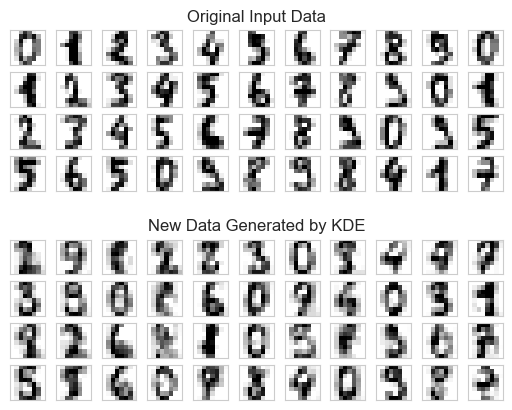

In [22]:
# 학습된 KDE 모델로부터 44개의 새로운 데이터를 샘플링합니다.
# 이 데이터는 15차원 PCA 공간에 존재합니다.
new_data_pca = kde.sample(44, random_state=0)

# inverse_transform을 사용하여 15차원 데이터를 원래의 64차원 이미지 공간으로 복원합니다.
new_data = pca.inverse_transform(new_data_pca)

# 데이터를 4x11 그리드 형태로 재구성합니다.
new_data = new_data.reshape((4, 11, -1))
real_data = digits.data[:44].reshape((4, 11, -1))

# 원본 숫자와 새로 생성된 숫자를 함께 시각화하여 비교합니다.
fig, ax = plt.subplots(9, 11, subplot_kw=dict(xticks=[], yticks=[]))

for j in range(11):
    # 가운데 행은 공백으로 비워둡니다.
    ax[4, j].set_visible(False)
    for i in range(4):
        # 위쪽 4행: 원본 손글씨 숫자 이미지
        im_real = ax[i, j].imshow(real_data[i, j].reshape((8, 8)),
                                  cmap=plt.cm.binary, interpolation='nearest')
        im_real.set_clim(0, 16)
        
        # 아래쪽 4행: KDE로 생성한 새로운 손글씨 숫자 이미지
        im_new = ax[i + 5, j].imshow(new_data[i, j].reshape((8, 8)),
                                     cmap=plt.cm.binary, interpolation='nearest')
        im_new.set_clim(0, 16)

ax[0, 5].set_title('Original Input Data')
ax[5, 5].set_title('New Data Generated by KDE')

plt.show()